In [1]:
# import modules
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcdefaults
from matplotlib.ticker import MultipleLocator
import numpy as np

# Define the relative path to the hamageolib package
root_path = os.path.join(Path().resolve().parent.parent.parent)
package_path = os.path.join(root_path, "hamageolib")

if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))

# import local modules
from hamageolib.research.haoyuan_2d_subduction.legacy_tools import SlabTemperature
from hamageolib.utils.handy_shortcuts_haoyuan import Mute
import hamageolib.utils.plot_helper as plot_helper

# unit converting
year = 365 * 24 * 3600.0 # year to second
cm_per_yr = 0.01 / year # cm/year to m/s

# Apply offsets to slab surface to get mantle wedge profiles

## Run test case with profile offsets

Below we run a test and plot the results

In [2]:
apply_case_offset = False

if apply_case_offset:

    case_path = os.path.join(root_path, "big_tests", "TwoDSubduction", 'EBA_CDPT_test_perplex_mixing_log')

    from hamageolib.utils.file_reader import read_aspect_header_file

    # Check if the folder exists and contains test files
    if not os.path.exists(case_path) or not os.listdir(case_path):
        raise FileExistsError("Skipping test: big test contents not found in 'big_tests/'.")

    # Make output directory and clear old files
    o_dir = os.path.join(root_path, "dtemp", "TwoDSubduction_vtk_pp")
    if not os.path.isdir(o_dir):
        os.mkdir(o_dir)
    o_file = os.path.join(o_dir, "slab_temperature_00104.txt")
    if os.path.isfile(o_file):
        os.remove(o_file)

    vtu_snapshot = 104 # 0 Ma
    _, _, _ = SlabTemperature(case_path, vtu_snapshot, o_file, output_slab=True, fix_shallow=True, offsets=[-5e3, -10e3])
    assert(os.path.isfile(o_file))  # assert the outputs of temperature profiles

    pd_data = read_aspect_header_file(o_file)

Figure on the left shows the points on different profiles. Here we apply offset of 5 km, 10 km, respectively to the slab surface. Figure on the right is the related T profiles

In [3]:
if apply_case_offset:

    fig = plt.figure(figsize=(5*2, 5))
    gs = gridspec.GridSpec(1, 2)

    # create mask for offset data
    mask_mh = (pd_data['x bot']**2.0 + pd_data['y bot']**2.0 < 6371e3**2.0)
    mask0 = (pd_data['x offset 0']**2.0 + pd_data['y offset 0']**2.0 < 6371e3**2.0)
    mask1 = (pd_data['x offset 1']**2.0 + pd_data['y offset 1']**2.0 < 6371e3**2.0)

    # 1: plot the coordinates
    ax = fig.add_subplot(gs[0, 0])

    ax.plot(pd_data['x']/1e3, pd_data['y']/1e3, label="surface")
    ax.plot(pd_data['x bot'][mask_mh]/1e3, pd_data['y bot'][mask_mh]/1e3, label="moho")
    ax.plot(pd_data['x offset 0'][mask0]/1e3, pd_data['y offset 0'][mask0]/1e3, label="offset 0")
    ax.plot(pd_data['x offset 1'][mask1]/1e3, pd_data['y offset 1'][mask1]/1e3, label="offset 1")

    ax.set_xlim([4000.0, 5500.0])
    ax.set_ylim([3500.0, 3800.0])

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.legend()

    # 1: plot the temperatures
    ax = fig.add_subplot(gs[0, 1])

    ax.plot(pd_data["Ttop"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Tbot"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Toffset 0"], pd_data["depth"]/1e3)
    ax.plot(pd_data["Toffset 1"], pd_data["depth"]/1e3)

    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 150])

    ax.invert_yaxis()

    ax.set_xlabel("T (K)")
    ax.set_ylabel("Depth (km)")

    ax.grid()

# Analytical solution from England & Wilkins, 2004

## First, we create an instance of the corner flow model.

In [4]:
solve_England_Wilkins_2004 = True

if solve_England_Wilkins_2004:

    from hamageolib.core.AnalyticalSolution import VISCOUS_CORNER_FLOW

    theta_d = np.pi / 4.0 # dipping angle
    mu = 1e21 # mantle viscosity
    U0 =  1 * cm_per_yr # convergence rate

    # make directory to save results
    result_p_dir = os.path.join(root_path, "dtemp")
    if not os.path.isdir(result_p_dir):
        os.mkdir(result_p_dir)
    result_dir = os.path.join(result_p_dir, "England_Wilkins_2004")
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)

    # coordinate values
    x = np.linspace(-1000e3, 1000e3, 200)
    y = np.linspace(0, 1000e3, 150)
    xx, yy = np.meshgrid(x, y)

    # initiate arrays to save values
    uu = np.zeros(xx.shape)
    vv = np.zeros(xx.shape)
    PP = np.zeros(xx.shape)

    # solve the problem
    VCF = VISCOUS_CORNER_FLOW()
    VCF.PrescribeDipVelocity(theta_d, U0)
    VCF.PrescribeDomainViscosity(mu)
    VCF.SolveArcCorner()
    VCF.SolveOceanicCorner()

    # mesh the solution
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            u, v, _ = VCF.GetFlowVelocity(xx[i, j], yy[i, j])
            P, _ = VCF.GetPressure(xx[i, j], yy[i, j])
            uu[i, j] = u
            vv[i, j] = v
            PP[i, j] = P
    vv_mag = (uu**2.0 + vv**2.0) ** 0.5

Plot the Results

Saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/solution_layout.pdf


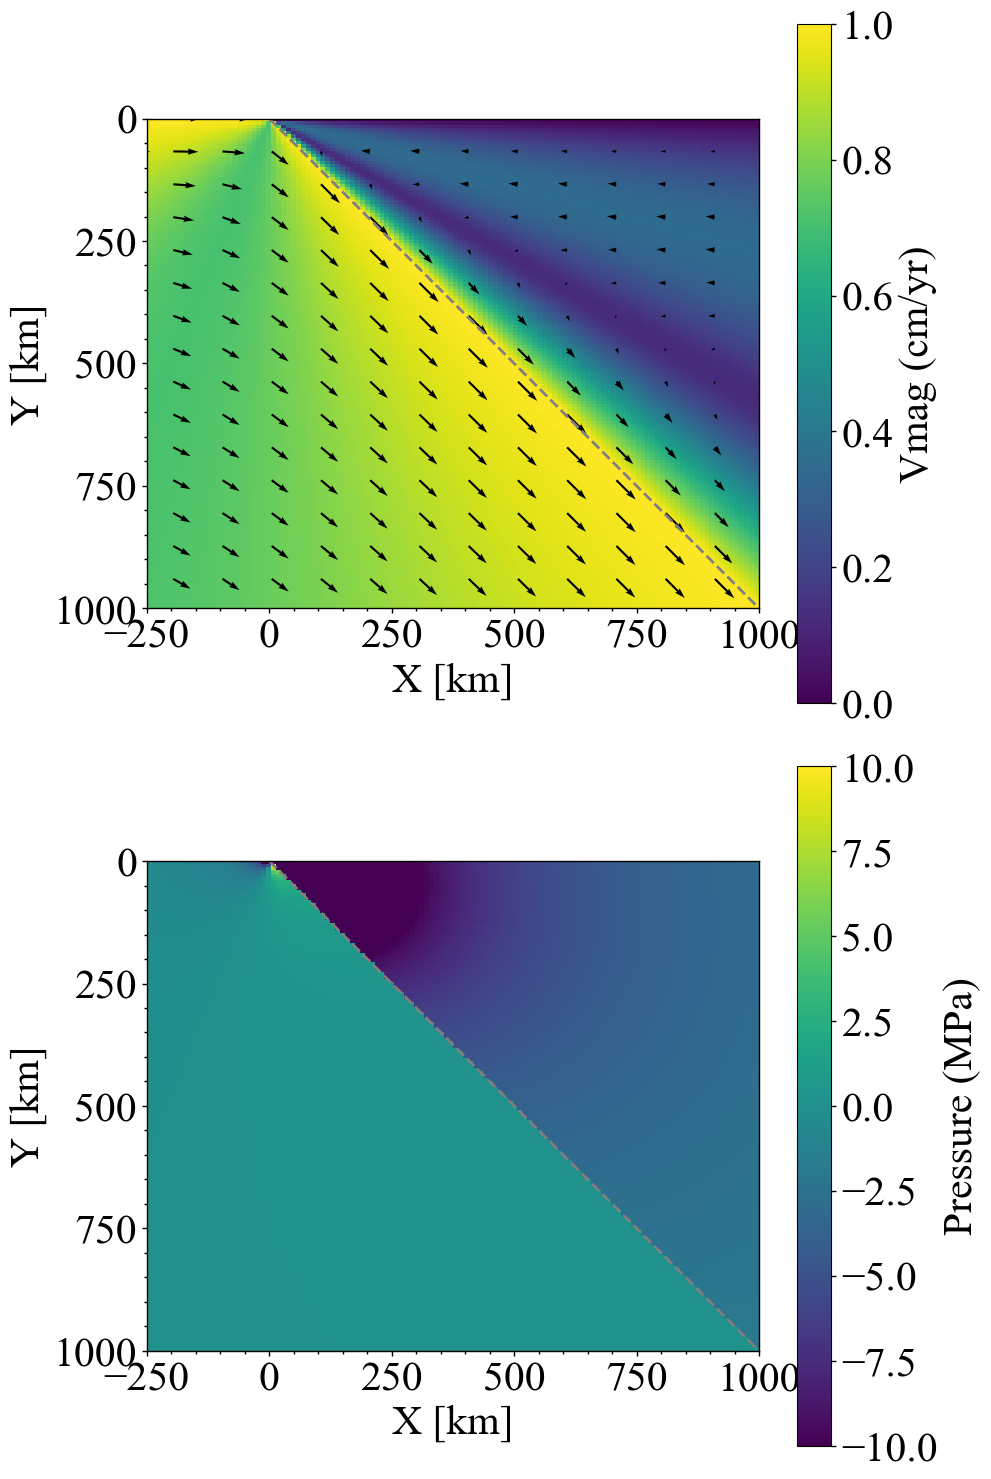

In [5]:
if solve_England_Wilkins_2004:

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (-250.0, 1000.0)
    x_tick_interval = 250.0   # tick interval along x
    y_lim = (0.0, 1000.0)
    y_tick_interval = 250.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    surface_xs = np.linspace(0, np.linalg.norm(xx, np.inf), 100)
    surface_ys = surface_xs * np.tan(theta_d)
    # Plot the solution
    fig = plt.figure(tight_layout=True, figsize=(10, 15))
    gs = gridspec.GridSpec(2, 1)

    # velocity magnitude and velocity direction
    ax = fig.add_subplot(gs[0, 0])  
    h = ax.pcolormesh(xx/1e3, yy/1e3, vv_mag / cm_per_yr)
    skip = (slice(None, None, 10), slice(None, None, 10))   # resample the quiver, add in a stride
    ax.quiver(xx[skip]/1e3, yy[skip]/1e3, uu[skip]/cm_per_yr, vv[skip]/cm_per_yr, angles='xy')

    ax.plot(surface_xs, surface_ys, color="tab:gray", linestyle="--")  # plot the slab surface

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax, label='Vmag (cm/yr)')

    # pressure
    ax1 = fig.add_subplot(gs[1, 0])  
    h = ax1.pcolormesh(xx/1e3, yy/1e3, PP/1e6, vmin=-10, vmax=10)
    ax1.plot(surface_xs, surface_ys, color="tab:gray", linestyle="--")  # plot the slab surface

    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax1.invert_yaxis()
    ax1.set_aspect('equal', adjustable='box')

    ax1.set_xlabel('X [km]')
    ax1.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax1, label='Pressure (MPa)')

    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax1.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Reset rcParams to defaults
    fig_path = os.path.join(result_dir, "solution_layout.pdf")
    fig.savefig(fig_path)
    print("Saved figure: %s" % fig_path)

    rcdefaults()

## Next, we solve the analytic solution and reproduce Fig.5

In [6]:
if solve_England_Wilkins_2004:

    from hamageolib.core.AnalyticalSolution import WK2004
    
    constants = WK2004.Constants(
        age=100.0e6*year,            # s
        U=0.1/year,                # m/s
        theta_d=np.pi/6.0, # radians
        a=100e3,               # meters
        zw=60e3,
        Ta=1280.0 + 273.15,             # Kelvin
        Tsf=273.15,
        kappa=8e-7,
        rho=3300.0,
        cp=1e3, # J Kg^-1 K^-1
        plate_T_model=0
    )

    WK_model = WK2004(constants)

Test computation at a certain depth

Note here, we can set to use_top_thickness. This will compute the top thickness shallower than zw from the diffusive thickness.

In [7]:
# todo_smooth
print(WK_model.ss_temperature(59e3, use_top_thickness=True, top_thickness_smooth=True, debug=True))
print(WK_model.ss_temperature(61e3, use_top_thickness=True, top_thickness_smooth=True, debug=True))

alpha =  5456.18768005647
T1 = 273.15, self.Tsf = 273.15, erf_multiplier = 61.89338153458767, erf_factor = 9.163907646131872, denominator = 1.886226925452758, erf(erf_factor) = 1.0, Ts = 305.96332733585655
305.96332733585655
alpha =  964.2903121138627
T1 = 395.9436055443863, self.Tsf = 273.15, erf_multiplier = 10.938624493421425, erf_factor = 9.012427665031758, denominator = 1.154036815627977, erf(erf_factor) = 1.0, Ts = 389.03211764720555
alpha =  5547.894735843498
T1 = 395.9436055443863, self.Tsf = 273.15, erf_multiplier = 62.933679289371184, erf_factor = 9.012427665031758, denominator = 1.886226925452758, erf(erf_factor) = 1.0, Ts = 371.6149738202505
389.03211764720555


## Benchmark: Results of surface temperature

(Keep this section the same to section in the OneNote)

Results from reproducing their fig 5:
	
From the definition of r, it only works when D > zw
	
T1 approaches 0 when r = 0 (eq 15);
Alpha (thickness of the advective layer) is also 0. 
-> Ts would be 0.0 at D = zw
	 
Different regime of heating
1. Heating from the wedge
	Most of the cases fall into this region
	Mantle wedge T > slab surface T
2. Heating from the subducting plate
	Thin subducting plate and slow convergence
	Mantle wedge T < slab surface T


saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/EW_2005_fig5_1_0.png


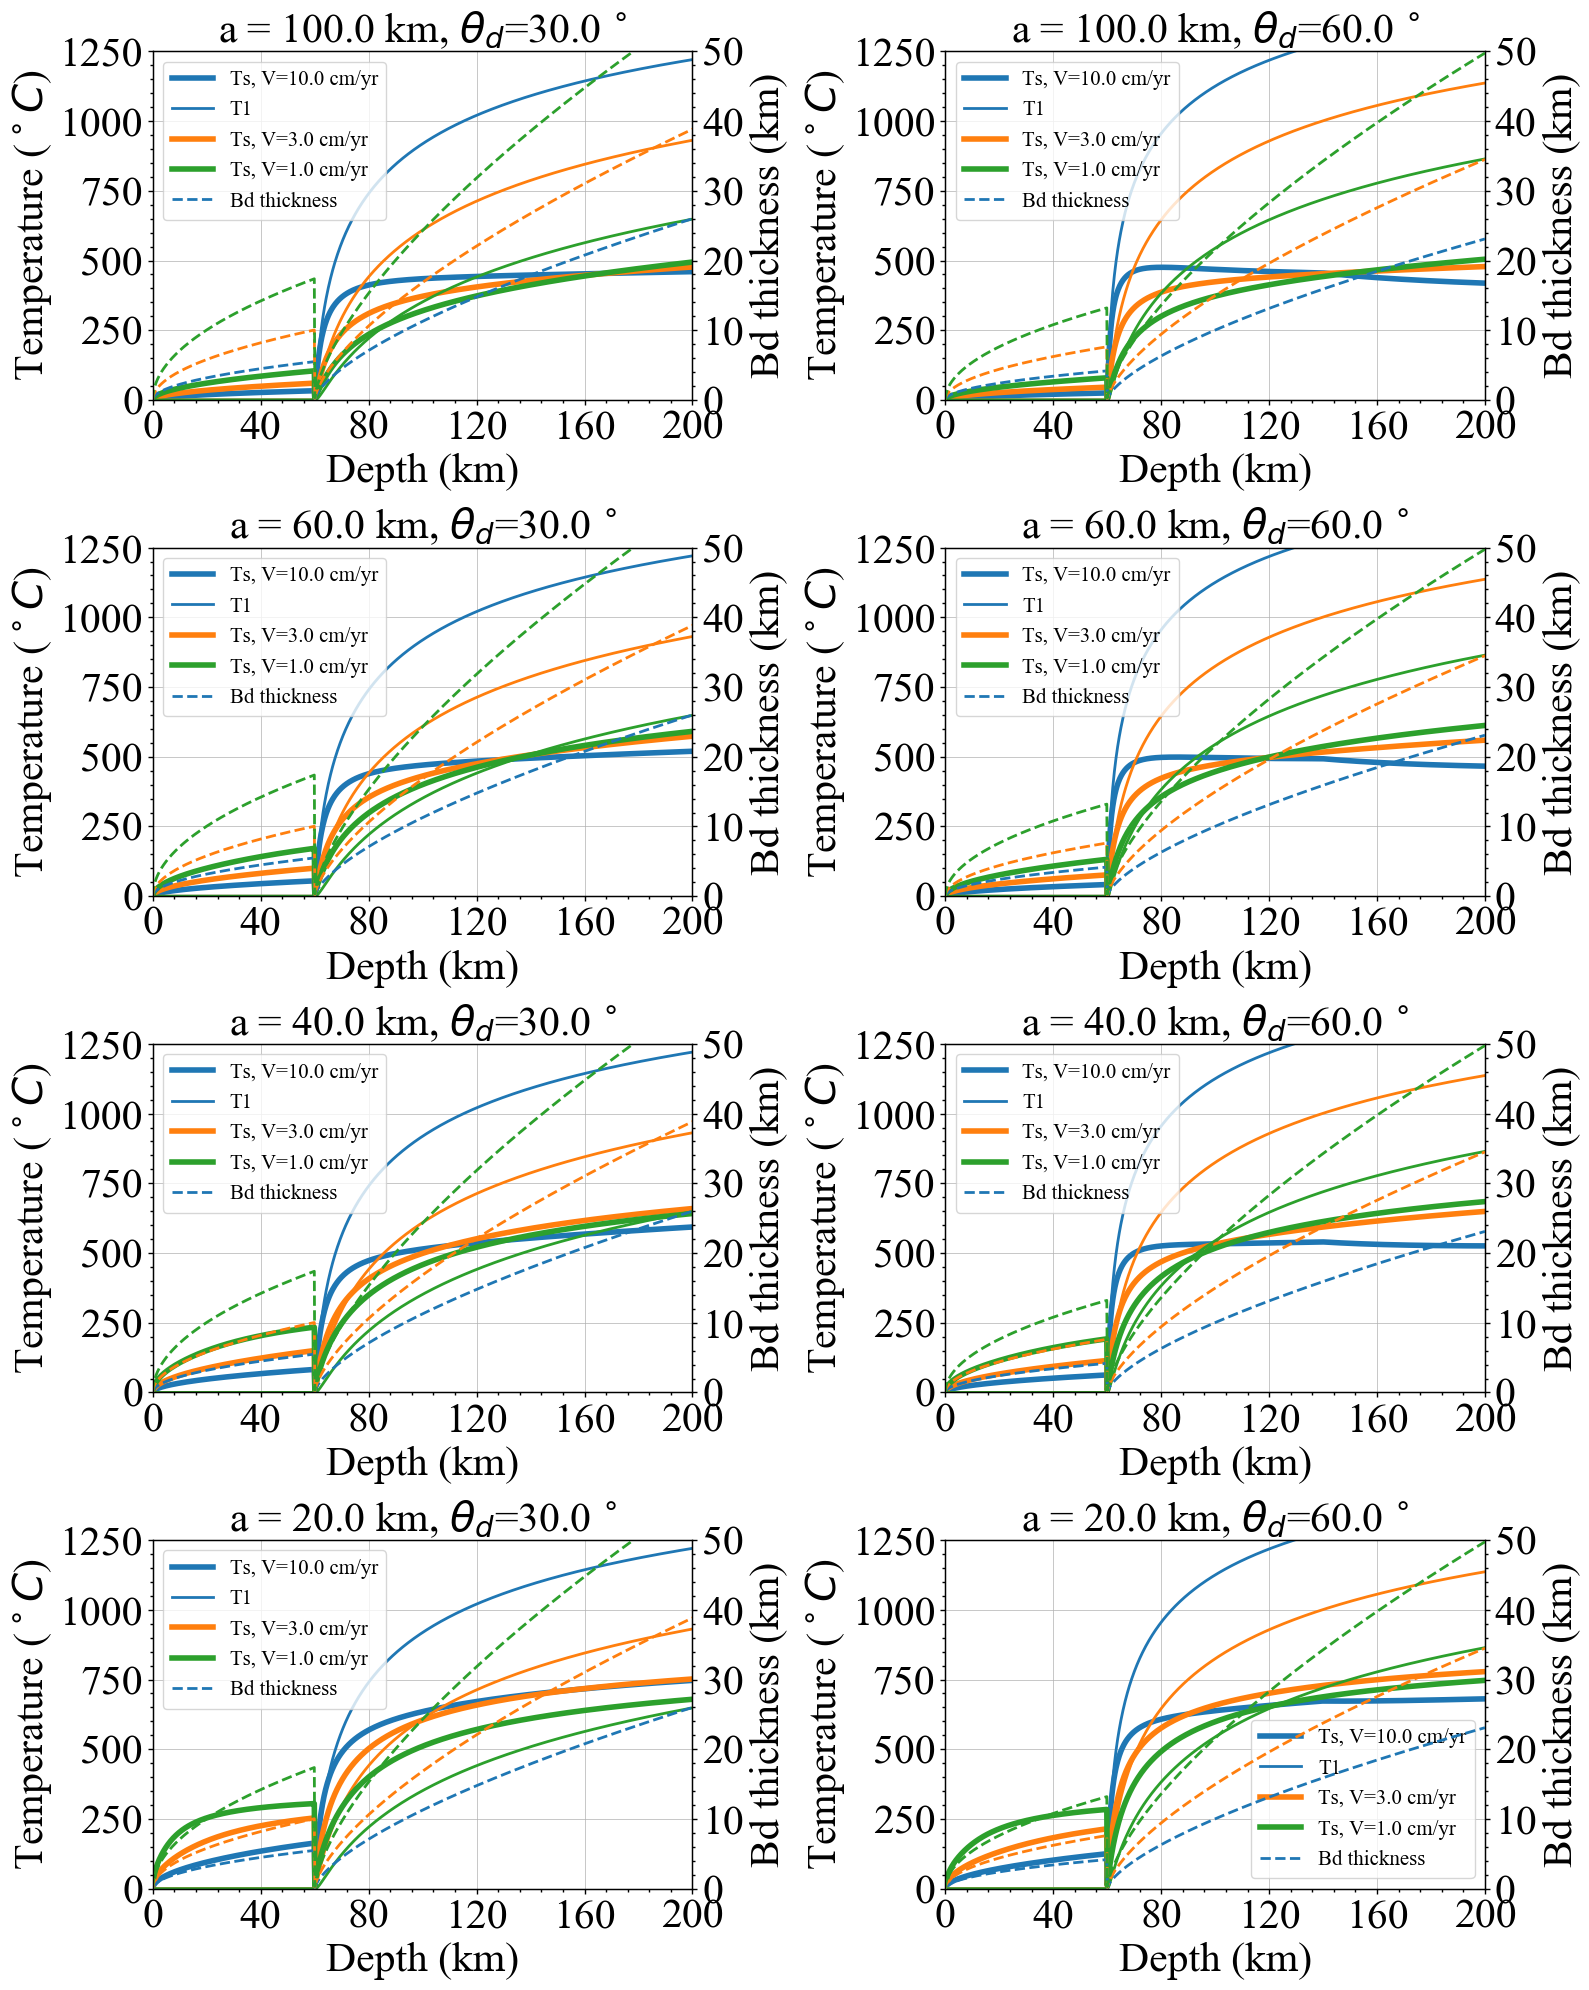

In [8]:
if solve_England_Wilkins_2004:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 200.0)
    x_tick_interval = 40.0   # tick interval along x
    y_lim = (0.0, 1250.0)
    y_tick_interval = 250.0  # tick interval along y
    y_lim1 = (0.0, 50.0)
    y_tick_interval1 = 10.0  # tick interval along y, ax1
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # assign overriding plate thickness
    zw = 60e3
    use_top_thickness=True
    top_thickness_smooth=False
    WK_model.zw = zw

    # assign depths
    depths = np.linspace(0, 200e3, 1000)
    # mask = (depths > zw)  # use this option when using the advective thickness
    mask = np.full(depths.shape, 1, dtype=bool)  # use this option when using the top thickness

    # create grid of theta_d and a
    theta_d_array = [np.pi/6.0, np.pi/3.0]
    a_array = [100e3, 60e3, 40e3, 20e3]
    U_array = [0.1/year, 0.03/year, 0.01/year]

    # create figure 
    fig = plt.figure(figsize=(8*len(theta_d_array)*scaling_factor, 5*len(a_array)*scaling_factor), tight_layout=True)
    gs = gridspec.GridSpec(len(a_array), len(theta_d_array))

    for i_theta, theta_d in enumerate(theta_d_array):
        for j_a, a in enumerate(a_array):
            # add axis to plot 
            ax = fig.add_subplot(gs[j_a, i_theta])
            ax1 = ax.twinx()

            # set theta_d and a in model
            WK_model.theta_d = theta_d
            WK_model.a = a

            for k_U, U in enumerate(U_array):

                # set U in model
                WK_model.U = U

                # compute mantle wedge temperature

                # compute slab surface temperature
                T1 = np.full(depths.shape, WK_model.Tsf)
                Ts = np.full(depths.shape, WK_model.Tsf)
                alphas = np.full(depths.shape, 0.0)

                with Mute():
                    T1[mask] = WK_model.mw_temperature(depths[mask])
                    Ts[mask] = WK_model.ss_temperature(depths[mask], use_top_thickness=use_top_thickness,\
                                                   top_thickness_smooth=top_thickness_smooth)
                    alphas[mask] = WK_model.top_thickness(depths[mask])


                # plot Ts vs depths
                if k_U == 0:
                    _label = "Ts, V=" + str(np.round(U*year*100.0)) + " cm/yr"
                    _label1 = "T1"
                    _label2 = "Bd thickness"
                else:
                    _label = "Ts, V=" + str(np.round(U*year*100.0)) + " cm/yr"
                    _label1 = None
                    _label2 = None
                ax.plot(depths/1e3, Ts-273.15, label=_label, linestyle="-", linewidth=4*scaling_factor, color=default_colors[k_U])
                ax.plot(depths/1e3, T1-273.15, label=_label1, linestyle="-", linewidth=2*scaling_factor, color=default_colors[k_U])

                # plot thickness vs depths
                ax1.plot(depths/1e3, alphas/1e3, linestyle="--", linewidth=2*scaling_factor, color=default_colors[k_U], label=_label2)
                

            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            
            ax1.set_ylim(y_lim1)

            ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
            ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
            ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
            ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
            
            ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
            ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))

            ax.set_xlabel("Depth (km)")
            ax.set_ylabel(r"Temperature ($^\circ C$)")
            _title = "a = %.1f km, " % (a/1e3) + r"$\theta_d$="+str(np.round(np.degrees(theta_d)))+r" $^{\circ}$"

            ax1.set_ylabel("Bd thickness (km)")

            ax.set_title(_title)

            # Get the handles and labels from both axes
            # Combine them
            # Add the combined legend to ax
            handles_ax, labels_ax = ax.get_legend_handles_labels()
            handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
            combined_handles = handles_ax + handles_ax1
            combined_labels = labels_ax + labels_ax1
            ax.legend(combined_handles, combined_labels, loc='best')  # You can customize loc

            ax.grid()

            # Adjust spine thickness for this plot
            for spine in ax.spines.values():
                spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    fig_path = os.path.join(result_dir, "EW_2005_fig5_%d_%d.png" % (use_top_thickness, top_thickness_smooth))

    fig.savefig(fig_path)

    print("saved figure: %s" % fig_path)

    # Reset rcParams to defaults

    rcdefaults()

## Temperature within the thermal thickness

First, we compute temperature conditions on different profiles

In [ ]:
if solve_England_Wilkins_2004:
    
    # assign overriding plate thickness
    zw = 60e3
    use_top_thickness=True
    top_thickness_smooth=False
    WK_model.zw = zw

    # assign depths
    depths = np.linspace(0, 200e3, 1000)
    mask_zw = (depths > zw)  # use this option when using the advective thickness
    mask = np.full(depths.shape, 1, dtype=bool)  # use this option when using the top thickness

    # assign values of theta_d, a and U
    theta_d = np.pi/3.0
    a = 100e3
    U = 0.1/year
    WK_model.theta_d = theta_d
    WK_model.a = a
    WK_model.U = U

    # array of distance to slab surface
    y_array = [2.5e3, 5e3, 7.5e3, 10e3, 15e3] # distance from the slab surface
    
    # compute slab surface temperature
    T1 = np.full(depths.shape, WK_model.Tsf)
    Ts = np.full(depths.shape, WK_model.Tsf)
    alphas = np.full(depths.shape, 0.0)
    Tbd_array = []
    
    with Mute():
        T1[mask] = WK_model.mw_temperature(depths[mask])
        Ts[mask] = WK_model.ss_temperature(depths[mask], use_top_thickness=use_top_thickness,\
                                       top_thickness_smooth=top_thickness_smooth)
        alphas[mask] = WK_model.top_thickness(depths[mask])
    
    for i_y, y in enumerate(y_array):
        ys = np.full(depths.shape, y)
        mask_y = (ys < alphas) # make sure y is smaller than alpha
        ys[~mask_y] = alphas[~mask_y]

        Tbd = np.full(depths.shape, 273.15)
        with Mute():
            Tbd[mask_zw] = WK_model.bd_temperature_by_zw(depths[mask_zw], ys[mask_zw])
        
        Tbd_array.append(Tbd)

    # todo_EW 

Then we plot it same way as in the paper

saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/EW_2005_bd_temperature_a100.0km_theta_d60.0deg_U10.0cmyr.png


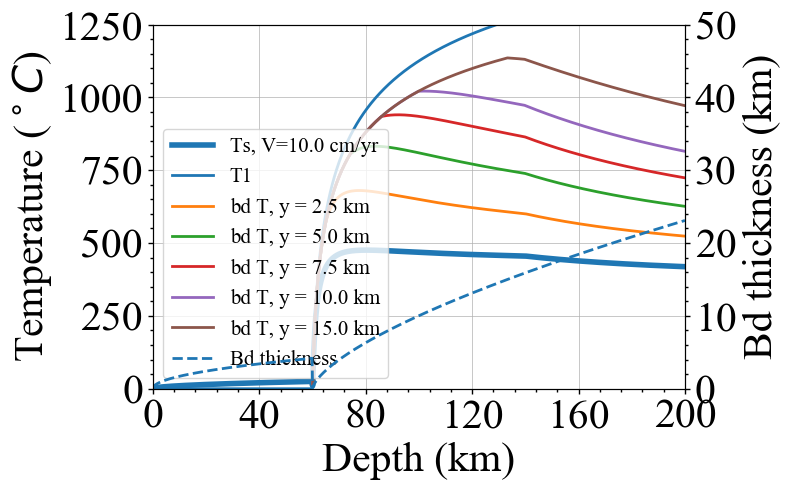

In [10]:
if solve_England_Wilkins_2004:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 200.0)
    x_tick_interval = 40.0   # tick interval along x
    y_lim = (0.0, 1250.0)
    y_tick_interval = 250.0  # tick interval along y
    y_lim1 = (0.0, 50.0)
    y_tick_interval1 = 10.0  # tick interval along y, ax1
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # create figure 
    fig, ax = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor), tight_layout=True)
    ax1 = ax.twinx()

    # plot Ts vs depths
    _label = "Ts, V=" + str(np.round(U*year*100.0)) + " cm/yr"
    _label1 = "T1"
    _label2 = "Bd thickness"
    ax.plot(depths/1e3, Ts-273.15, label=_label, linestyle="-", linewidth=4*scaling_factor, color=default_colors[0])
    ax.plot(depths/1e3, T1-273.15, label=_label1, linestyle="-", linewidth=2*scaling_factor, color=default_colors[0])
    ax1.plot(depths/1e3, alphas/1e3, linestyle="--", linewidth=2*scaling_factor, color=default_colors[0], label=_label2)
    
    for i_y, y in enumerate(y_array):
        _label3 = "bd T, y = %.1f km" % (y/1e3)
        ax.plot(depths[mask_zw]/1e3, Tbd_array[i_y][mask_zw]-273.15, label=_label3, linestyle="-", linewidth=2*scaling_factor, color=default_colors[i_y+1])
        pass

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
            
    ax1.set_ylim(y_lim1)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))

    # Get the handles and labels from both axes
    # Combine them
    # Add the combined legend to ax
    handles_ax, labels_ax = ax.get_legend_handles_labels()
    handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
    combined_handles = handles_ax + handles_ax1
    combined_labels = labels_ax + labels_ax1
    ax.legend(combined_handles, combined_labels, loc='best')  # You can customize loc

    ax.grid()

    ax.set_xlabel("Depth (km)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
            
    ax1.set_ylabel("Bd thickness (km)")

    
    # save figure
    fig_path = os.path.join(result_dir, "EW_2005_bd_temperature_a%.1fkm_theta_d%.1fdeg_U%.1fcmyr.png" % (a/1e3, np.degrees(theta_d), U*100.0*year))
    fig.savefig(fig_path)

    print("saved figure: %s" % fig_path)

    # Reset rcParams to defaults

    rcdefaults()

Then we plot it similarly to our manuscript

saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/England_Wilkins_2004/EW_2005_bd_temperature_melting_a100.0km_theta_d60.0deg_U10.0cmyr.png


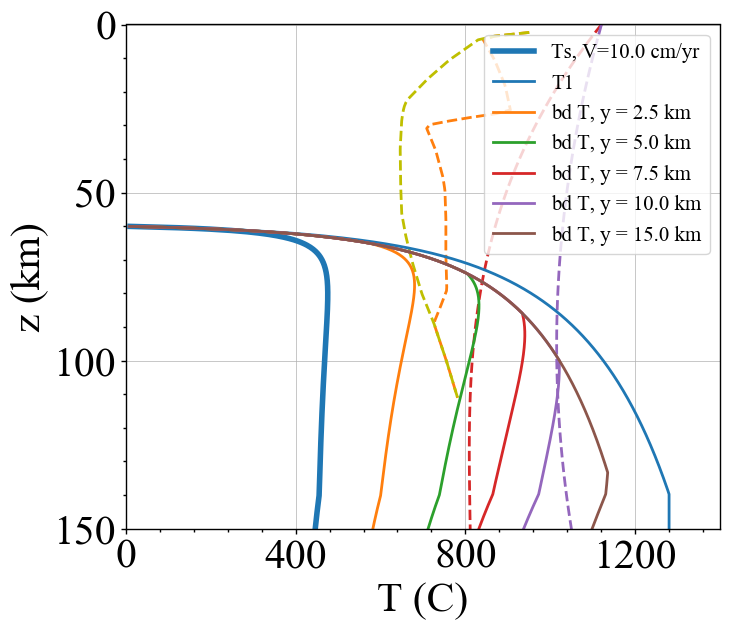

In [12]:
from hamageolib.core.melt import ROCK_MELTING

if solve_England_Wilkins_2004:
    
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from matplotlib.ticker import MultipleLocator

    # set time and depth to plot
    max_depth = 150e3

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Scaling parameters for plots.
    scaling_factor = 1.0  # General scaling factor for the plot size.
    font_scaling_multiplier = 3.0  # Extra scaling for fonts.
    legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
    line_width_scaling_multiplier = 2.0  # Extra scaling for line widths
    x_tick_interval = 400.0   # tick interval along x
    y_tick_interval = 50.0   # tick interval along x
    n_minor_ticks = 4  # number of minor ticks between two major ones


    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
        
    # Plot: Combine slab surface and moho into single figures
    fig, ax = plt.subplots(figsize=(8*scaling_factor, 7*scaling_factor), tight_layout=True)

    # plot melting curves
    # Define pressure ranges for each curve in Pascals (Pa)
    rock_melting = ROCK_MELTING() # Initialize the ROCK_MELTING instance

    pressure_ranges = {
    "dry_peridotite": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "water_saturated_peridotite_low_pressure": np.linspace(0, 6e9, 100),  # 0 to 6 GPa
    "water_saturated_peridotite_high_pressure": np.linspace(6e9, 12e9, 100),  # 6 to 12 GPa
    "eclogite": np.linspace(3e9, 7.5e9, 100),  # 3 to 7.5 GPa
    "peridotite_aH2O_0.1": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.3": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.5": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.7": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "basalt_aH2O_0_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_0_8": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_1_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_1_8": np.linspace(0.078e9, 3.665e9, 100)  # 0.078 to 3.665 GPa}
    }

    styles = {
    "dry_peridotite": ("k", "-"),
    "water_saturated_peridotite_low_pressure": (default_colors[3], "--"),
    "water_saturated_peridotite_high_pressure": (default_colors[3], "--"),
    "eclogite": ("r", "-"),
    "peridotite_aH2O_0.1": ("c", "-"),
    "peridotite_aH2O_0.3": ("c", "--"),
    "peridotite_aH2O_0.5": ("g", "-"),
    "peridotite_aH2O_0.7": (default_colors[4], "--"),
    "basalt_aH2O_0_3": (default_colors[1], "--"),
    "basalt_aH2O_0_8": ("m", "--"),
    "basalt_aH2O_1_3": ("y", "--"),
    "basalt_aH2O_1_8": ("y", "--"),
    } # Colors and line styles for each curve

    solidus_list = ["basalt_aH2O_0_3", "basalt_aH2O_1_8",\
                    "water_saturated_peridotite_low_pressure", "water_saturated_peridotite_high_pressure", "peridotite_aH2O_0.7"]
    

    for name in solidus_list:
        # Plot each solidus curve
        # Hide the label names here in case there are too many in the figure
        func = rock_melting.solidus_data[name]
        P_Pa = pressure_ranges[name]  # Pressures in Pa
        T_K = func(P_Pa)  # Temperatures in K
        depth_km = P_Pa / 33e6
        color, linestyle = styles[name]
        ax.plot(T_K - 273.15, depth_km, color=color, linestyle=linestyle) # , label=name.replace("_", " ").title())

    
    # plot Ts vs depths
    _label = "Ts, V=" + str(np.round(U*year*100.0)) + " cm/yr"
    _label1 = "T1"
    _label2 = "Bd thickness"
    ax.plot(Ts[mask_zw]-273.15, depths[mask_zw]/1e3,  label=_label, linestyle="-", linewidth=4*scaling_factor, color=default_colors[0])
    ax.plot(T1[mask_zw]-273.15, depths[mask_zw]/1e3, label=_label1, linestyle="-", linewidth=2*scaling_factor, color=default_colors[0])
    # ax1.plot(alphas/1e3, depths/1e3,  linestyle="--", linewidth=2*scaling_factor, color=default_colors[0], label=_label2)
    
    for i_y, y in enumerate(y_array):
        _label3 = "bd T, y = %.1f km" % (y/1e3)
        ax.plot(Tbd_array[i_y][mask_zw]-273.15, depths[mask_zw]/1e3,  label=_label3, linestyle="-", linewidth=2*scaling_factor, color=default_colors[i_y+1])
        pass

    
    ax.set_xlim([0.0, 1400.0])
    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.set_ylim([max_depth/1e3, 0])
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("T (C)")
    ax.set_ylabel("z (km)")

    ax.legend() # hide legend, see AI finalized figures.
    ax.grid()

    # Adjust spine thickness for this plot
    all_axes = fig.get_axes()
    for ax in all_axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # save figure
    fig_path = os.path.join(result_dir, "EW_2005_bd_temperature_melting_a%.1fkm_theta_d%.1fdeg_U%.1fcmyr.png" % (a/1e3, np.degrees(theta_d), U*100.0*year))
    fig.savefig(fig_path)

    print("saved figure: %s" % fig_path)

    # show figure
    plt.show()

    mpl.rcParams.update(mpl.rcParamsDefault)